In [4]:
# 02_image_download.ipynb
# ==================================================
# Continue downloading SDSS images in batches
# ==================================================

# -----------------------------
# 1️⃣ Imports
# -----------------------------
import os
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# -----------------------------
# 2️⃣ Paths and Config
# -----------------------------
CLEANED_CSV = "../data/merged_gz2_sdss.csv"   # full merged dataset
IMG_DIR = "../data/images"
os.makedirs(IMG_DIR, exist_ok=True)

MAPPING_CSV = "../data/image_mapping.csv"

# SDSS cutout parameters
IMG_SIZE = 128   # pixels
SCALE = 0.2      # arcsec/pixel

# -----------------------------
# 3️⃣ Load cleaned dataset
# -----------------------------
df = pd.read_csv(CLEANED_CSV)
print("Dataset loaded:", df.shape)

# -----------------------------
# 4️⃣ Function to download SDSS images
# -----------------------------
def fetch_sdss_image(ra, dec, filename, scale=SCALE, size=IMG_SIZE):
    """
    Fetch SDSS galaxy cutout image given RA & DEC.
    Save as JPEG file.
    """
    url = (
        f"http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg"
        f"?ra={ra}&dec={dec}&scale={scale}&width={size}&height={size}"
    )
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(filename)
        return True
    except Exception as e:
        print(f"❌ Failed to fetch {filename}: {e}")
        return False

# -----------------------------
# 5️⃣ Batch Download Control
# -----------------------------

# Load existing mapping if available
if os.path.exists(MAPPING_CSV):
    mapping_df = pd.read_csv(MAPPING_CSV)
    done_idxs = set(mapping_df["idx"].tolist())
    print(f"Already have {len(done_idxs)} images in mapping CSV.")
else:
    mapping_df = pd.DataFrame()
    done_idxs = set()

# ⚡ Define batch range
START_IDX = 1000   # start from 1000 since first batch already done
END_IDX   = 6000   # you can adjust upper bound as needed
BATCH = df.iloc[START_IDX:END_IDX]

# Exclude already downloaded
df_to_download = BATCH[~BATCH.index.isin(done_idxs)]
print(f"Downloading {len(df_to_download)} galaxies in this batch ({START_IDX} → {END_IDX})")

new_mapping = []

for idx, row in tqdm(df_to_download.iterrows(), total=len(df_to_download)):
    ra, dec = row['ra'], row['dec']
    filename = os.path.join(IMG_DIR, f"{idx}.jpg")
    
    if not os.path.exists(filename):
        success = fetch_sdss_image(ra, dec, filename)
        if not success:
            continue
    
    new_mapping.append({
        "idx": idx,
        "image_filename": filename,
        "ra": ra,
        "dec": dec,
        **{col: row[col] for col in df.columns if 't0' in col}  # only morphology labels
    })

# Merge with existing mapping
if new_mapping:
    mapping_df = pd.concat([mapping_df, pd.DataFrame(new_mapping)], ignore_index=True)
    mapping_df.to_csv(MAPPING_CSV, index=False)
    print(f"✅ Mapping CSV updated: {MAPPING_CSV}")
    print(f"Total images now: {len(mapping_df)}")
else:
    print("No new images downloaded in this batch.")


Dataset loaded: (48664, 248)


  1%|▉                                                                                 | 60/5000 [02:15<6:06:41,  4.45s/it]

❌ Failed to fetch ../data/images/1059.jpg: HTTPConnectionPool(host='skyserver.sdss.org', port=80): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=254.45672607421875&dec=39.21688079833984&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x1379cee40>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


 23%|██████████████████▊                                                             | 1174/5000 [41:53<4:46:12,  4.49s/it]

❌ Failed to fetch ../data/images/2173.jpg: HTTPConnectionPool(host='skyserver.sdss.org', port=80): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=189.75341796875&dec=5.434262752532959&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x1379cf6e0>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


 24%|███████████████████▍                                                            | 1218/5000 [43:31<4:37:19,  4.40s/it]

❌ Failed to fetch ../data/images/2217.jpg: HTTPConnectionPool(host='skyserver.sdss.org', port=80): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=118.57040405273438&dec=40.124698638916016&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x1379cf7d0>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


 75%|██████████████████████████████████████████████████████████▏                   | 3733/5000 [2:11:06<1:38:36,  4.67s/it]

❌ Failed to fetch ../data/images/4732.jpg: HTTPSConnectionPool(host='skyserver.sdss.org', port=443): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=127.8452377319336&dec=49.22727966308594&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x1379cf6e0>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


 76%|███████████████████████████████████████████████████████████▎                  | 3800/5000 [2:13:28<1:26:34,  4.33s/it]

❌ Failed to fetch ../data/images/4799.jpg: HTTPConnectionPool(host='skyserver.sdss.org', port=80): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=230.8366241455078&dec=57.06744384765625&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x1379ce300>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


 80%|██████████████████████████████████████████████████████████████▍               | 3999/5000 [2:20:16<1:18:26,  4.70s/it]

❌ Failed to fetch ../data/images/4998.jpg: HTTPSConnectionPool(host='skyserver.sdss.org', port=443): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=135.23162841796875&dec=50.235347747802734&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x137a840e0>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


 87%|█████████████████████████████████████████████████████████████████████▊          | 4362/5000 [2:32:39<48:14,  4.54s/it]

❌ Failed to fetch ../data/images/5361.jpg: HTTPSConnectionPool(host='skyserver.sdss.org', port=443): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=234.93162536621097&dec=3.1632883548736572&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x137a85b20>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


 88%|██████████████████████████████████████████████████████████████████████          | 4377/5000 [2:33:16<45:30,  4.38s/it]

❌ Failed to fetch ../data/images/5376.jpg: HTTPConnectionPool(host='skyserver.sdss.org', port=80): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=152.2996063232422&dec=54.179500579833984&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x137a86030>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


 91%|████████████████████████████████████████████████████████████████████████▌       | 4539/5000 [2:38:56<34:22,  4.47s/it]

❌ Failed to fetch ../data/images/5538.jpg: HTTPConnectionPool(host='skyserver.sdss.org', port=80): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=228.3129425048828&dec=2.8169233798980713&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x113bebc80>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


 92%|█████████████████████████████████████████████████████████████████████████▌      | 4596/5000 [2:41:00<29:17,  4.35s/it]

❌ Failed to fetch ../data/images/5595.jpg: HTTPConnectionPool(host='skyserver.sdss.org', port=80): Max retries exceeded with url: /dr16/SkyServerWS/ImgCutout/getjpeg?ra=252.9408264160156&dec=43.66568374633789&scale=0.2&width=128&height=128 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x1379cc620>, 'Connection to skyserver.sdss.org timed out. (connect timeout=10)'))


100%|████████████████████████████████████████████████████████████████████████████████| 5000/5000 [2:54:36<00:00,  2.10s/it]


✅ Mapping CSV updated: ../data/image_mapping.csv
Total images now: 4990


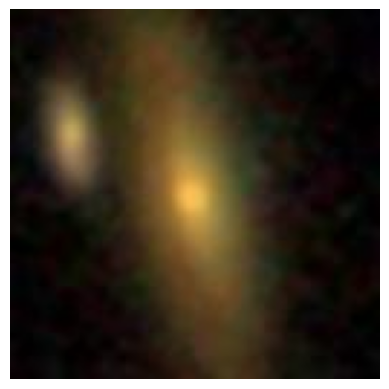

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("../data/images/5597.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()


In [21]:
import pandas as pd
import os

# Load combined CSV
combined_mapping = pd.read_csv("../data/combined_image_mapping.csv")

# Decide on the target folder
TARGET_FOLDER = "data/images_combined"
os.makedirs(TARGET_FOLDER, exist_ok=True)

# Update all paths to point to the target folder
def standardize_path(path):
    # Keep only the filename
    filename = os.path.basename(path)
    # Return the new full path
    return os.path.join(TARGET_FOLDER, filename)

combined_mapping["image_filename"] = combined_mapping["image_filename"].apply(standardize_path)

# Save updated CSV
combined_mapping.to_csv("data/combined_image_mapping.csv", index=False)
print("✅ Paths standardized. CSV updated.")


✅ Paths standardized. CSV updated.
